In [7]:
from src.forest_generator import generate_barabasi_forest, generate_random_graph
from src.emn_model import (
    get_clean_dataset,
    generate_bipartite_network,
    diffusion_dynamics,
    tree_project_network)
import pandas as pd
import networkx as nx
import numpy as np
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import pickle
from os.path import exists
from math import ceil
from copy import deepcopy
from scipy.integrate import solve_ivp
from itertools import combinations_with_replacement

TEX_PLOTS = False

# Plotting config
if TEX_PLOTS:
    plt.rc("text", usetex=True)
    plt.rc("font", family="serif")
    plt.rc("text.latex", preamble=r"""
         \usepackage{times}
         \usepackage{mathptmx}
         \usepackage{siunitx}""")
else:
    plt.rc("text", usetex=False)

mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["font.size"] = 14
mpl.rcParams["axes.labelsize"] = mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.2
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["lines.linewidth"] = 1

cmap = mpl.cm.get_cmap("Dark2")
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=cmap.colors)

np.random.seed(1231)
NPZ_DIR = "data"

def get_save_path(path):
    while path[0] == '/':
        path = path[1:]

    return f"{NPZ_DIR}/{path}"

In [8]:
""" Some helper functions """
def avg_degree_ne(node_count, edge_count):
    """Not to be confused with degree centrality."""
    return 2 * edge_count / node_count

def avg_degree(G):
    """Not to be confused with degree centrality"""
    return avg_degree_ne(len(G.nodes), len(G.edges))

def list_map(f, xs):
    return list(map(f, xs))

def array_map(f, xs):
    return np.array(list_map(f, xs))

def split3(xs, N):
    """A 3D system is three 1D systems"""
    return np.array(xs[:N]), np.array(xs[N:2*N]), np.array(xs[2*N:])

def mean_std(xs):
    return np.mean(xs), np.std(xs)

def _split_timeseries_internal(xs, N):
    return xs[:,:N,:], xs[:,N:2*N:,:], xs[:,2*N:,:]

In [9]:
df = get_clean_dataset()
B = generate_bipartite_network(df)
G = tree_project_network(B)
pos = nx.spring_layout(G, k=3, seed=99192, weight=None)

In [10]:
def excess_edges(G, target_avg_degree):
    """
    For graph `G`, count the number of edges that should be removed to
    get closer to get an average degree of `target_avg_degree`.
    
    The resulting value should give a graph that is either the closest or
    second closest to the avergae degree.
    """
    k_avg = avg_degree(G)
    excess_avg_degree = (k_avg - target_avg_degree)
    excess = round(excess_avg_degree * len(G.nodes)/2)
    return excess

# Characteristic Time Experiments
We estimate the effective characteristic time of the network diffusion process, i.e. the time-scale over which the network settles into a steady-state. In general the characteristic time depends on the degree distribution of the network. We would like to observe the difference between the different network types
- Ecological
- Barabasi-Albert
- Erdoes Reyni

as the average degree $\langle k \rangle$ is varied.

In [11]:
def extract_initial_values(G):
    """
    Extract initial values of the dynamical variables from the data stored in the graph nodes
    """
    plant_carbon_0 = np.array(list(nx.get_node_attributes(G, "carbon_value").values()))
    root_carbon_0 = 0.1 * plant_carbon_0
    plant_diameter_0 = np.array(list(nx.get_node_attributes(G, "diameter").values()))
    return root_carbon_0, plant_carbon_0, plant_diameter_0

In [12]:
def characteristic_time_expmt(
        G, save_path, target_avg_degrees, *args, time_steps=301, reps=5, verbose=False):
    """
    For a starting graph `G`, vary the average degree by removing different numbers of edges,
    and allow the network to evolve.
    """
    network_edges = list(G.edges)
    node_count = len(G.nodes)

    n_edge_remove_list = list(
        map(lambda x: excess_edges(G, x), target_avg_degrees))

    # initialise empty results
    remove_results = {
        k: {
            "networks": [],
            "data": []
        }
        for k in n_edge_remove_list
    }

    # initial values of dynamical variables
    root_carbon_0, plant_carbon_0, plant_diameter_0 = extract_initial_values(G)

    (t_range, D_C, uptake_ps, f, k, g, c, rho) = args

    ts = np.linspace(*t_range, time_steps)
    if not exists(save_path):
        print("[INFO] Computing from scratch.")
        for j, n_edge_remove in enumerate(n_edge_remove_list):
            if not verbose:
                print(f"node_count {j+1}/{len(n_edge_remove_list)}")
            for i in range(reps):
                # copy original graph
                G_r = deepcopy(G)
                # randomly remove required number of edges
                edges_idx = np.random.choice(
                    len(network_edges), size=n_edge_remove, replace=False)

                G_r.remove_edges_from([network_edges[edge_idx]
                                      for edge_idx in edges_idx])
                remove_results[n_edge_remove]["networks"].append(G_r)
                
                x0 = np.concatenate([root_carbon_0, plant_carbon_0, plant_diameter_0])
                args = (G_r, D_C, node_count, uptake_ps, f, k, c, g, rho)
                sol = solve_ivp(diffusion_dynamics, t_range,
                                x0,
                                args=args, dense_output=True, method="BDF")
                z = sol.sol(t)
                remove_results[n_edge_remove]["data"].append(z)

        with open(save_path, "wb") as f:
            pickle.dump(remove_results, f)
    else:
        print("[INFO] Deserialising last result")
        with open(save_path, "rb") as f:
            remove_results = pickle.load(f)
        print("[INFO] Done!")

    return remove_results

In [13]:
def process_remove_results(G, n_edge_remove_list, remove_results):
    """Use the simulation resutls to estimate the standard deviation of the
    time-series of root-nutrient concentration. Since the root-nutrients evolve
    asymptotically towards zero concentration, the standard deviation of the resulting
    timeseries will can be thought of as an "effective characteristic time" a la linear
    systems with negative real parts in their spectrum.
    """
    node_count = N = len(G.nodes)
    edge_count = len(G.edges)

    names = ["roots", "plants", "biomass"]
    ret_results = {name: [[], []] for name in names}

    # for each average degree
    for n_edge_rmv, data in remove_results.items():
        timeseries_data = np.array(data["data"])  # great identifier naming
        roots, plants, biomass = _split_timeseries_internal(timeseries_data, N)
        for name, component in zip(names, [roots, plants, biomass]):
            # alternatively, just fit an exponential curve thingy to the guys
            inter_node_variance_data = np.array(
                [np.var(xs, axis=1) for xs in component])
            c_times = np.std(inter_node_variance_data, axis=1)
            μ, σ = mean_std(c_times)
            ret_results[name][0].append(μ)
            ret_results[name][1].append(σ)

    for k, v in ret_results.items():
        ret_results[k] = np.array(v)

    return ret_results

## Ecological Network

In [14]:
def actual_avg_degrees(G, edge_remove_list):
    """
    Edge removal does not result in exactly the desired average degree,
    so calculate the average degree again.
    """
    node_count = len(G.nodes)
    edge_count = len(G.edges)
    return [2 * (edge_count - edge_remove_count) /
            node_count for edge_remove_count in edge_remove_list]

In [15]:
# choose target degrees
target_avg_degrees = np.linspace(0.2, 15.0, 11)
n_edge_remove_list = list_map(lambda x: excess_edges(G, x), target_avg_degrees)
ec_avg_degrees = actual_avg_degrees(G, n_edge_remove_list)

# args
t_range = (0, 16_000)
D_C = 5.0e-4
uptake_ps = (0.55, 0.0, 55.0)
f = 5.0e-4  # sensitive w.r.t plant carbon deposition
k = 0.6
g = 0.004
c = 0.82
rho = 0.01

params = (t_range, D_C, uptake_ps, f, k, g, c, rho)

save_path = get_save_path("diffusion_time_scales.npz")
real_network_remove_results = characteristic_time_expmt(G, save_path, target_avg_degrees,
                                                        *params)

ec_results = process_remove_results(
    G, n_edge_remove_list, real_network_remove_results)

[INFO] Deserialising last result
[INFO] Done!


## BA Network

In [16]:
node_count = len(G.nodes)
G_BA = generate_barabasi_forest(n_nodes=node_count, m=9, seed=0x1337)

In [17]:
n_edge_remove_list = list_map(lambda x: excess_edges(G_BA, x), target_avg_degrees)
ba_avg_degrees = actual_avg_degrees(G_BA, n_edge_remove_list)

# assuming same parameters as before
save_path = get_save_path("diffusion_time_scales_BA.npz")

ba_network_remove_results = characteristic_time_expmt(G_BA, save_path, target_avg_degrees,
                                                        *params)

ba_results = process_remove_results(G_BA, n_edge_remove_list, ba_network_remove_results)

[INFO] Deserialising last result
[INFO] Done!


## ER Network

In [18]:
G_ER = generate_random_graph(node_count, p=0.3)
n_edge_remove_list = list_map(lambda x: excess_edges(G_ER, x), target_avg_degrees)
er_avg_degrees = actual_avg_degrees(G_ER, n_edge_remove_list)

# assuming same parameters as before
save_path = get_save_path("diffusion_time_scales_ER.npz")

ba_network_remove_results = characteristic_time_expmt(G_ER, save_path, target_avg_degrees,
                                                        *params)

er_results = process_remove_results(G_ER, n_edge_remove_list, ba_network_remove_results)

[INFO] Deserialising last result
[INFO] Done!


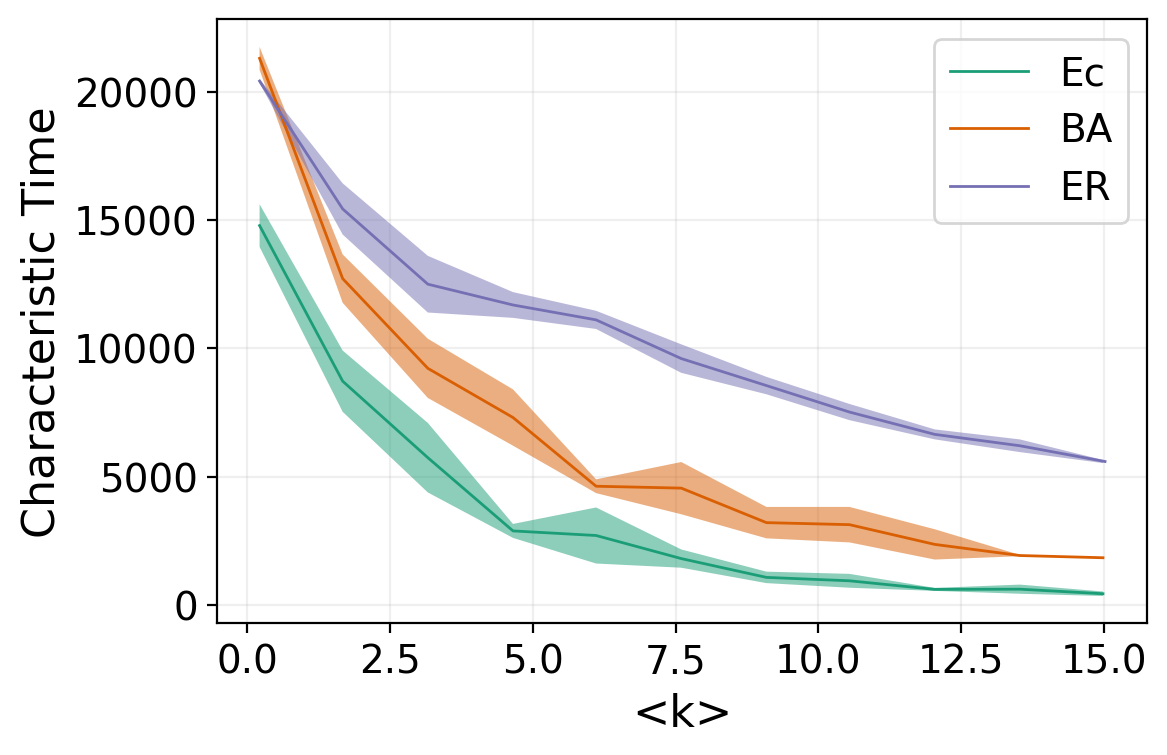

In [23]:
final_results = [ec_results, ba_results, er_results]
final_plot_data = [data["roots"] for data in final_results]

plt.plot(ec_avg_degrees, final_plot_data[0][0], label="Ec")
plt.fill_between(ec_avg_degrees, final_plot_data[0][0] + final_plot_data[0][1], final_plot_data[0][0] - final_plot_data[0][1], alpha=0.5)
plt.plot(ba_avg_degrees, final_plot_data[1][0], label="BA")
plt.fill_between(ec_avg_degrees, final_plot_data[1][0] + final_plot_data[1][1], final_plot_data[1][0] - final_plot_data[1][1], alpha=0.5)
plt.plot(er_avg_degrees, final_plot_data[2][0], label="ER")
plt.fill_between(ec_avg_degrees, final_plot_data[2][0] + final_plot_data[2][1], final_plot_data[2][0] - final_plot_data[2][1], alpha=0.5)
plt.xlabel("<k>")
plt.ylabel("Characteristic Time")
plt.legend()
plt.show()